# Fundamentals of Simulation Methods, WiSe 2020/2021
## Problem Set 7, 2021-01-13
### Author: Elias Olofsson


In [1]:
import numpy as np
import matplotlib.pyplot as plt 

## 1. 1D Heat diffusion problem (10 pts)

### Implementation of a sparse representation of a tridiagonal matrix, and complementary function for matrix multiplication.

In [2]:
def create_mat(n_size):
    """
    Create representation of the sparse tridiagonal matrix A. 
    
    Parameters:
    -----------
    n_size: int
        Size of the sqaure matrix A.
    
    Returns:
    --------
    A_sparse: np.array
        Sparse representation of matrix A, shape=(3,n_size).
        First row  --> Upper diagonal in A.
        Middle row --> Diagonal in A.
        Last row   --> Lowe diagonal in A. 
    """
    A_sparse = np.ones((3,n_size))
    
    A_sparse[0,-1] = 0 # Set last element in upper diagonal to 0.
    A_sparse[-1,0] = 0 # Set first element in lower diagonal to 0.
    
    A_sparse[1,1:-1] = -2 # Set diagonal elements to -2.
    A_sparse[1,0]    = -3 # Set end elements on the diagonal to -3.
    A_sparse[1,-1]   = -3
    
    return A_sparse

In [3]:
def multiply(A, x):
    """
    Multiply a sparse tridiagonal matrix A with a vector x.
    
    Parameters:
    -----------
    A: np.array 
        Representation of sparse tridiagonal matrix A, shape=(3,n_size).
    x: np.array
        Arbitrary vector to be multiplied of shape=(n_size,). 
        
    Returns:
    --------
    np.array
        Result of matrix multiplication of A and x, shape=(n_size,).
    """
    return np.sum(A * np.stack([np.roll(x,-1),x,np.roll(x,1)]), axis=0)

### Test and verify that matrix multiplication is done correctly.

In [4]:
N = 10 # Number of gridpoints

# Random vector to be multiplicated.
x = np.random.random(N)

# Create sparse matrix A.
A = create_mat(N) 
print(A, "\n")
print(A.shape, "\n")

# Create non-sparse matrix A.
A_nonsparse = np.diag(A[1])
A_nonsparse[np.arange(N-1),np.arange(N-1)+1] = A[0,:-1]
A_nonsparse[np.arange(N-1)+1,np.arange(N-1)] = A[2,1:]
print(A_nonsparse, "\n")
print(A_nonsparse.shape)

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [-3. -2. -2. -2. -2. -2. -2. -2. -2. -3.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.]] 

(3, 10) 

[[-3.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -3.]] 

(10, 10)


In [5]:
# Perform matrix multiplication with numpy built-in function.
out1 = A_nonsparse @ x

# My function, using the sparse matrix implementation.
out2 = multiply(A,x)

# Compare matrices element-wise.
equal = (out1 == out2).all()

if equal:
    print("Matrices are exactly equal.")
else:
    print("Matrices are not exactly equal.") 
    print(f"Largest elementwise relative difference between the matrices: {np.max(np.abs(out1-out2)/out1):.6}")

Matrices are not exactly equal.
Largest elementwise relative difference between the matrices: 2.0233e-16


### Implement a solver of linear system of equations, using the forward-elimination backward-substitution method (Tridiagonal matrix algorithm, TDMA).

In [6]:
def tdma(A, b_vec):
    """
    Tridiagonal matrix algorithm (Thomas Algorithm), solving a linear matrix equation
    Ax = b, using the forward-elimination backward-substitution method.
    
    Parameters:
    -----------
    A: np.array
        Sparse representation of tridiagonal matrix A, shape=(3, n_size). 
    b: np.array
        Vector of shape=(n_size,).
    Returns:
    --------
    np.array
        Vector of shape=(n_size,) corrsponding to the numerical solution x of the
        linear matrix equation Ax = b.
    """
    # Size of vectors and matrix.
    N = b_vec.shape[0]
    x = np.zeros_like(b_vec)
    
    # Make copies of A and b and rename to fit scheme used in Wikipedia article.
    a = A[2].copy() # Lower diagonal (a[i=0] = 0)
    b = A[1].copy() # Diagonal 
    c = A[0].copy() # Upper diagonal (c[i=N-1] = 0)
    
    d = b_vec.copy()
    
    # Forward elimination.
    for i in range(1, N):
        w = a[i]/b[i-1]
        b[i] = b[i] - w*c[i-1]         
        d[i] = d[i] - w*d[i-1]
    
    # Backwards substitution.
    x[-1] = d[-1]/b[-1]
    for i in range(N-2, -1, -1):
        x[i] = (d[i] - c[i]*x[i+1]) / b[i]
        
    return x

### Test and verify that the implemented matrix solver works.

In [7]:
# Generate a random vector b.
b = np.random.random(N)

# Solve using numpy built-in linear solver.
out1 = np.linalg.solve(A_nonsparse, b)

# Solve using my implementation of the TDMA-solver.
out2 = tdma(A, b)

# Compare results
equal = (out1 == out2).all()
if equal:
    print("Solutions are exactly equal.")
else:
    print("Solutions are not exactly equal.") 
    print(f"Largest elementwise relative difference between the solutions: {np.max(np.abs(out1-out2)/out1):.6}")

Solutions are exactly equal.


### Use TDMA-implementation for solving the heat diffusion problem.

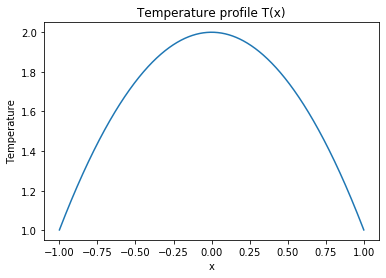

In [8]:
N   = 1000 # No. of gridpoints.
eps = 1    # Heat rate from radioactivity in solid material.
D   = 0.5  # Heat diffusion coefficient.
T0  = 1    # Dirichlet boundary condition: Temperature at x = ±L
L   = 1    # Length of domain.

h = 2*L/N  # Grid spacing.
x = np.linspace(-L+h/2, L-h/2, num=N) # Grid points 

# Create the appropriate matrix A.
A = create_mat(N)

# Get the constant vector b.
tmp = np.zeros(N)
tmp[[0,-1]] = 1
b = -eps*h**2/D - 2*T0*tmp

# Solve for the temperature
T = tdma(A, b)

# Save results for later
T_tdma = T
x_tdma = x

# Plotting
plt.figure()
plt.plot(x,T)
plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Temperature profile T(x)")
plt.savefig("tdma_T.pdf")

### Verify solution by computing the residual after multiplication with the matrix A.

In [9]:
residual = multiply(A, T) - b
print(np.max(np.abs(residual)))

6.581327415553298e-16


### Jacobi iteration

In [10]:
def jacobi(A, x, b):
    """
    Perform a single Jacobi iteration step.
    
    Parameters:
    -----------
    A: np.array
        Sparse representation of tridiagonal matrix A, shape=(3, n_size).
    x: np.array
        Previous Jacobi iteration step, shape=(n_size,).
    b: np.array
        Constant vector of shape=(n_size,).
        
    Returns:
    --------
    np.array
        Next Jacobi iteration step, shape=(n_size,).
    """
    # Pre-allocations
    U = np.zeros_like(A)
    D = np.zeros_like(A) 
    L = np.zeros_like(A)
    D_inv = np.zeros_like(A)
    
    # Decomposition of the matrix A
    U[0] = -A[0] # Upper diagonal
    D[1] = A[1] # Diagonal
    L[2] = -A[2] # Lower diagonal
    
    # Inverse of the diagonal matrix D
    D_inv[1] = 1/D[1]

    # Perform iteration
    x_next =  multiply(D_inv, b) + multiply(D_inv, multiply(L+U, x))
    
    return x_next

### Jacobi iteration, $N=8$ grid points

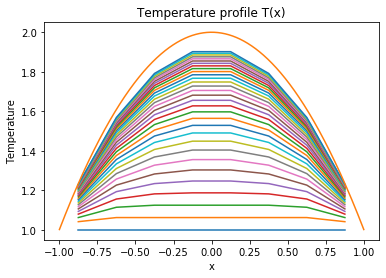

In [11]:
N   = 8    # No. of gridpoints.
eps = 1    # Heat rate from radioactivity in solid material.
D   = 0.5  # Heat diffusion coefficient.
T0  = 1    # Dirichlet boundary condition: Temperature at x = ±L
L   = 1    # Length of domain.

h = 2*L/N  # Grid spacing.
x = np.linspace(-L+h/2, L-h/2, num=N) # Grid points 

# Create the appropriate matrix A.
A = create_mat(N)

# Get the constant vector b.
tmp = np.zeros(N)
tmp[[0,-1]] = 1
b = -eps*h**2/D - 2*T0*tmp

# Initialize T
T = np.ones(N)

plt.figure()
plt.plot(x,T)

for i in range(30):
    # Solve for the temperature
    T = jacobi(A, T, b)
    plt.plot(x,T)
    
# Overplot the true solution found with the forward elimination, backward substitution.
plt.plot(x_tdma, T_tdma)

plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Temperature profile T(x)")
plt.savefig("jacobi8.pdf")

### Jacobi iteration, $N = 100$ grid points

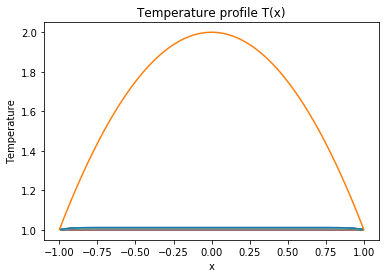

In [12]:
N   = 100  # No. of gridpoints.
eps = 1    # Heat rate from radioactivity in solid material.
D   = 0.5  # Heat diffusion coefficient.
T0  = 1    # Dirichlet boundary condition: Temperature at x = ±L
L   = 1    # Length of domain.

h = 2*L/N  # Grid spacing.
x = np.linspace(-L+h/2, L-h/2, num=N) # Grid points 

# Create the appropriate matrix A.
A = create_mat(N)

# Get the constant vector b.
tmp = np.zeros(N)
tmp[[0,-1]] = 1
b = -eps*h**2/D - 2*T0*tmp

# Initialize T
T = np.ones(N)

plt.figure()
plt.plot(x,T)

for i in range(30):
    # Solve for the temperature
    T = jacobi(A, T, b)
    plt.plot(x,T)
    
# Overplot the true solution found with the forward elimination, backward substitution.
plt.plot(x_tdma, T_tdma)

plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Temperature profile T(x)")
plt.savefig("jacobi100.pdf")

## 2. 1D Multigrid method (10 pts)

In [13]:
n   = 3    # Highest grid-level (grid resolution)
eps = 1    # Heat rate from radioactivity in solid material.
D   = 0.5  # Heat diffusion coefficient.
T0  = 1    # Dirichlet boundary condition: Temperature at x = ±L
L   = 1    # Length of domain.

def create_Abx(n):
    N = 2**n + 1               # No. of gridpoints.
    h = 2*L/(N-1)              # Grid spacing.
    x = np.linspace(-L, L, N)  # x-position of gridpoints.
    
    # Create matrix A
    dia = np.ones(N)
    dia[1:N-1] = -2
    A = np.diag(dia)                            # Diagonal
    A[np.arange(1,N-1), np.arange(N-2)] = 1     # Lower diagonal
    A[np.arange(1,N-1), np.arange(N-2)+2] = 1   # Upper diagonal

    # Create vector b
    vec = np.zeros(N)
    vec[[0,N-1]] = 1
    b = -eps*h**2/D * (1-vec) + T0 * vec
    
    return A, b, x

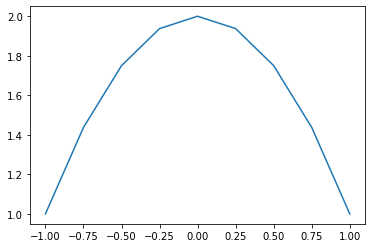

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [14]:
# Verifying that new problem formulation gives same result as in previous exercise.
A, b, x = create_Abx(n)
T = np.linalg.solve(A, b)
plt.plot(x, T)
plt.show()
print(A)

In [15]:
def restriction(n):
    N_in  = 2**n + 1      # Grid points before restriction
    N_out = 2**(n-1) + 1  # Grid points after restriction
    
    R = np.zeros((N_out, N_in))
    k = 0
    for i in range(1, N_out-1):
        R[i, np.arange(3)+2*k+1] = np.array([1/4,2/4,1/4])
        k += 1

    R[0,0] = 3/4
    R[0,1] = 1/4

    R[-1,-1] = 3/4
    R[-1,-2] = 1/4
    
    print(R, '\n')
    
    return R

In [16]:
def prolongation(n):
    N_in  = 2**n + 1      # Grid points before prolongation
    N_out = 2**(n+1) + 1  # Grid points after prologation
    
    P = np.zeros((N_out, N_in))
    k = 0
    for i in range(1, N_in-1):
        P[np.arange(3)+2*k+1, i] = np.array([1/2,1,1/2])
        k += 1

    P[0,0] = 1
    P[1,0] = 1/2

    P[-1,-1] = 1
    P[-2,-1] = 1/2
    
    print(P, '\n')
    
    return P

In [17]:
# Creating matrices A, vectors b and position vectors x for all grid resolutions,
# by direct coarse grid approximation.
A = [];  b = [];  x = []
for i in range(n+1):
    out = create_Abx(i)
    A.append(out[0])
    b.append(out[1])
    x.append(out[2])

# Printing the matrices.
for A_i in A:
    print(A_i, '\n')

[[1. 0.]
 [0. 1.]] 

[[ 1.  0.  0.]
 [ 1. -2.  1.]
 [ 0.  0.  1.]] 

[[ 1.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  1.]] 

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]] 



In [18]:
# Restriction matrices.
R = []
for i in range(n):
    R.append(restriction(i+1))

[[0.75 0.25 0.  ]
 [0.   0.25 0.75]] 

[[0.75 0.25 0.   0.   0.  ]
 [0.   0.25 0.5  0.25 0.  ]
 [0.   0.   0.   0.25 0.75]] 

[[0.75 0.25 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.5  0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.25 0.5  0.25 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.25 0.75]] 



In [19]:
# Prologation matrices.
P = []
for i in range(n):
    P.append(prolongation(i))

[[1.  0. ]
 [0.5 0.5]
 [0.  1. ]] 

[[1.  0.  0. ]
 [0.5 0.5 0. ]
 [0.  1.  0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]] 

[[1.  0.  0.  0.  0. ]
 [0.5 0.5 0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  1. ]] 



In [20]:
def jacobi_step(A, x, b):
    """
    Perform a single Jacobi iteration step. 
    
    Note: Not compatible with sparse matrix format above.
    
    Parameters:
    -----------
    A: np.array
        Square matrix A, shape=(n_size, n_size).
    x: np.array
        Previous Jacobi iteration step, shape=(n_size,).
    b: np.array
        Constant vector of shape=(n_size,).
        
    Returns:
    --------
    np.array
        Next Jacobi iteration step, shape=(n_size,).
    """
    U = -np.triu(A,k=1)
    L = -np.tril(A,k=-1)
    
    D_vec = np.diag(A)
    D_inv = np.diag(1/D_vec)
    
    return D_inv @ b + (D_inv @ ((L+U) @ x))

In [21]:
def V_cycle(x, b, level, A, R, P):
    """
    Perform a single V-cycle down to the lowest grid resolution. 
    Solving for x for the linear equation Ax = b.
    
    Parameters:
    -----------
    x: np.array
        Previous step's solution, vector of shape=(n_size, ).
    b: np.array
        Vector b in eq Ax = b, shape=(n_size, ).
    level: int
        Current grid level. Should be 
    A: list
        List of A matrices for each grid resolution, down to the
        finest level. Ascending order, i.e. A[0] corresponds to 
        the coarsest grid, A[-1] the finest.
    R: list
        List of restriction matrices R, in ascending order.
    P: list
        List of prologation matrices P, in ascending order.
    
    Returns:
    --------
    np.array
        Next iteration step of solution x, shape=(n_size,).
    """
    
    # Relaxation step (Jacobi)
    x = jacobi_step(A[level], x, b)
    
    # Compute residual
    r = b - A[level] @ x
    
    # Restrict residual to coarser mesh
    r_coarse = R[level-1] @ r
    
    eps = np.zeros_like(r_coarse)
    
    if level == 1:
        eps = jacobi_step(A[level-1], eps, r_coarse)
    else:
        eps = V_cycle(eps, r_coarse, level-1, A, R, P)
    
    # Prologation of error and correction
    x = x + P[level-1] @ eps
    
    # Further relaxation step (Jacobi)
    x = jacobi_step(A[level], x, b)    
    
    return x

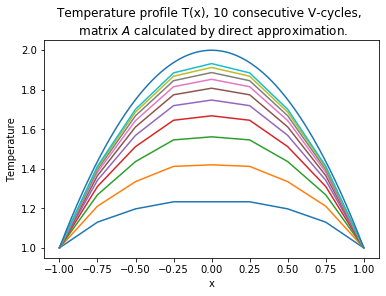

In [22]:
# From an initial guess of T=1, perform multiple sequential V-cycle iterations. 
T = np.ones_like(b[-1])
for i in range(10):
    T = V_cycle(T, b[-1], n, A, R, P)
    plt.plot(x[-1], T)
    
# Overplot the 'true' solution previously found from the forward elimination, backward substitution.
plt.plot(x_tdma, T_tdma)
plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Temperature profile T(x), 10 consecutive V-cycles, \n matrix $A$ calculated by direct approximation.")
plt.savefig("V_cycle_direct.pdf")

In [23]:
# Creating matrices A for lower grids through Galerkin coarse grid approximation.
A2 = [A[-1]]
for i in range(n-1, -1, -1):
    A2.append(R[i] @ A2[-1] @ P[i])
A2.reverse()

# Printing the matrices.
for A_i in A2:
    print(A_i, '\n')

[[0.421875 0.      ]
 [0.       0.421875]] 

[[ 0.5625  0.      0.    ]
 [ 0.0625 -0.125   0.0625]
 [ 0.      0.      0.5625]] 

[[ 0.75  0.    0.    0.    0.  ]
 [ 0.25 -0.5   0.25  0.    0.  ]
 [ 0.    0.25 -0.5   0.25  0.  ]
 [ 0.    0.    0.25 -0.5   0.25]
 [ 0.    0.    0.    0.    0.75]] 

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]] 



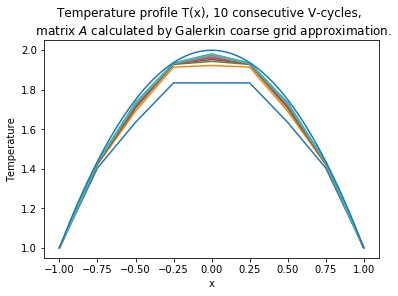

In [24]:
# From an initial guess of T=1, perform multiple sequential V-cycle iterations.
T = np.ones_like(b[-1])
for i in range(10):
    T = V_cycle(T, b[-1], n, A2, R, P)
    plt.plot(x[-1], T)

# Overplot the 'true' solution previously found from the forward elimination, backward substitution.
plt.plot(x_tdma, T_tdma)

plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Temperature profile T(x), 10 consecutive V-cycles, \n matrix $A$ calculated by Galerkin coarse grid approximation.")
plt.savefig("V_cycle_galerkin.pdf")